<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0901_Word2Vec_CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving t1.png to t1.png
User uploaded file "t1.png" with length 152714 bytes


In [16]:
from IPython.display import Image

# 1. Word2Vec 소개  


Mikolov와 그의 동료가 2013 년에 'Efficient Estimation of Word Representation in Vector Space'에서 제안한 2 가지 모델이 소위 Word2Vec의 시초라고 여겨지는 것 같다. 이번 글에서 나는 이 논문에서 제안된 2 가지 모델에 대해 소개하고 이것이 우리가 앞에서 알아보았던 NNLM (NPLM) 보다 더 좋은 성능을 제공한다는 것을 보인다.

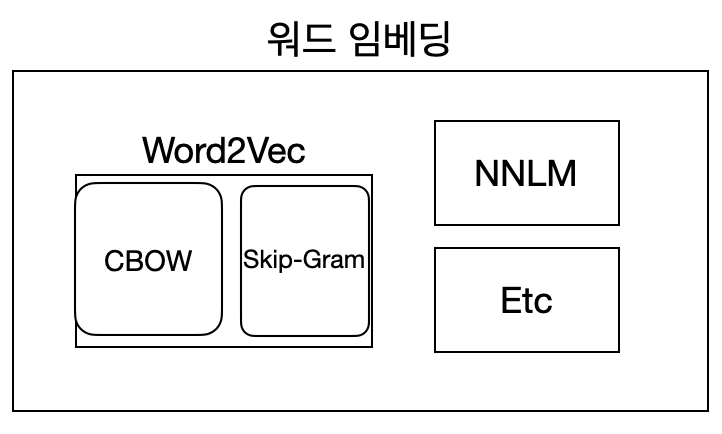

In [7]:
Image('w1.png',width=500)

## 1.0 논문 'Efficient Estimation of Word Representations in Vector Space' (2013)에 대한 간략한 요약  
  
본고는 큰 데이터셋에 있는 단어들의 분산 표현을 계산해주는 새로운 2 가지 모델을 소개한다. 이 모델들은 근래 들어 소위 Word2Vec이라 불리는 것들인데, CBOW, Skip-Gram 이 그것들이다. 제안된 이 모델들은 이전 모델들 ( 가령 NNLM 등) 보다 단어 간의 유사성 및 특정 단어를 예측할 때 연산적으로 효율적이지만 향상된 정확도를 보인다. 

## 1.1 NNLM vs Word2Vec  
  
앞에서 알아보았던 [NNLM](https://colab.research.google.com/drive/1ajh6ZbaxAUw91dqUw-eFCUU_7o_Bj653)은 이전 단어 시퀀스로부터 다음 단어를 예측하는 역할만 수행했다. 하지만 Word2Vec를 이용하면 그것보다 더 많은 역할을 수행할 수 있으며, 공학적인 이점도 얻을 수 있다:  
  
- (1) 한 문장 내의 어떤 자리에 있던 간에 하나의 단어(center word)를 다른 주변 단어 context words를 통해 예측할 수 있기 때문에 더 확장적인 역할을 수행할 수 있다.   
  
- (2) 이 기술은 단어들 간의 여러 측면의 유사성 -- 가령, 구문론적 유사성, 의미론적 유사성 등 -- 을 찾게 해준다.   
  
- (3) 대개의 경우에, Word2Vec 기술은 연산 복잡도 측면에 있어서 NNLM 보다 더 효율적이다.

## 1.2 Word2Vec의 동기

### NNLM

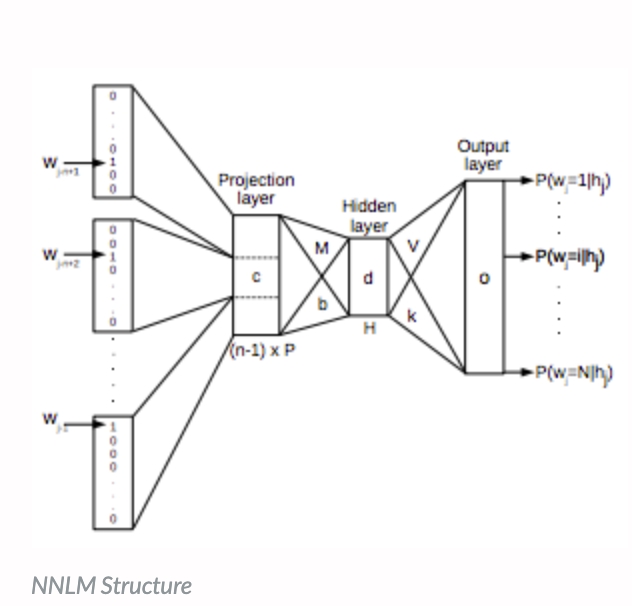

In [4]:
Image('v2.png',width=600)

 - 모델의 구성  
 
이전에 알아보았던 NNLM은 4 종류의 Layer로 구성되어 있었다: 입력층, 투사층, 은닉층, 출력층. 여기서 투사층이란 "활성화 함수가 존재하지 않으며 룩업 테이블이라는 연산을 담당하는 계층"을 일컫는데, 이것은 은닉층과 구분된다.   
- 연산적 복잡도  

모델의 연산적 복합도: "모델을 완전히 학습시킬 때 요구되는 매개변수의 개수"  
  

이것은 [입력층 -> 투사층]에서 N (배치 사이즈) x P (임베딩 사이즈) 만큼의 복잡도가 요구되고, [투사층 -> 은닉층]에서 N x P x H (은닉층 개수) 만큼의 복잡도가 요구되고, [은닉층 -> 출력층]에서 H x V (단어 집합 내의 단어의 개수) 만큼의 복잡도가 요구된다.    
  
- 따라서 이것의 복잡도는 NP + NPH + HV 가 요구된다.

#2. CBOW  
  
CBOW는 NNLM과 다소 다르다. 본고에 따르면 CBOW에는 NNLM과 다르게 비선형적 은닉층이 없다. 따라서 사실 이 논문을 따른다면 ReLU 같은 비선형 계층을 CBOW 모델에 도입시키지 않는 것이 적절하다. 왜냐하면 저자는 본고에서 이전 절에서 본 NNLM가 갖는 높은 복잡도는 대부분의 경우에 **모델의** **비선형적** **은닉층**에서 기인한다고 생각하기 때문이다.

* 일러두기: 위 엄밀한 구분에 따르면, 바로 위의 그림에 있는 hidden layer도 사실 projection layer여야 할 것이다. CBOW에서는 비선형적 은닉층이 없기 때문이고, 이것은 lookup table 연산을 수행하기 때문이다.

## 2.1 CBOW에 대한 상세한 설명  


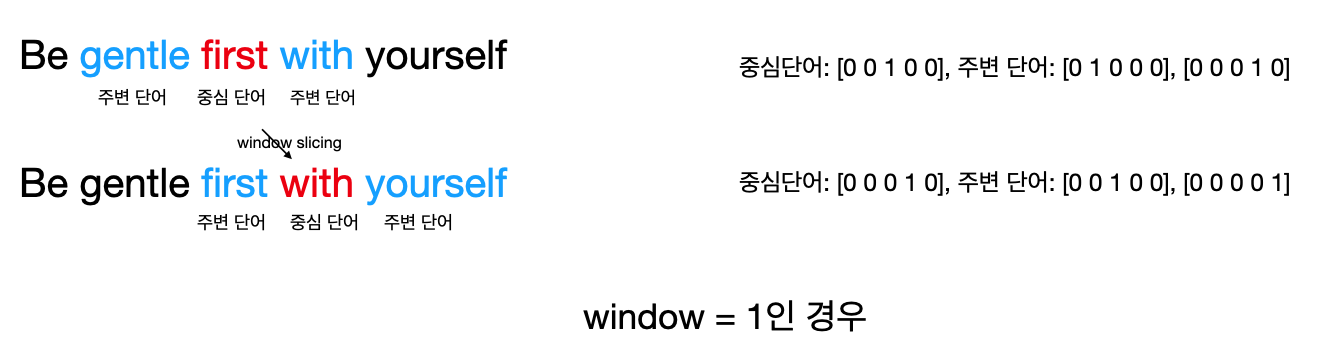

In [11]:
Image('wv1.png',width=800)

위 그림을 참고하여 CBOW가 수행하는 절차를 이해해보자. CBOW는 주변 단어 context words를 통해 중심 단어 centered word를 예측하는 역할을 수행한다.   

- **window**  
  
  window란 중심 단어 양 옆으로 각각 몇 개의 단어를 조사하는지에 대한 범위를 가리킨다. 가령, 위 그림 같이 'first'가 중심 단어일 때, 양 옆으로 놓여 있는 word를 각각 1 개씩 참고한다면, window는 1이다.   
- **window** **slicing**  
  
 위 같이 오른쪽으로 한 칸씩 이동하며 학습을 위한 dataset을 만드는 과정을 일컫는다.  
   
CBOW는 설정된 윈도우 범위에 따라 주변 단어로부터 중심 단어를 예측하고, 윈도우 슬라이싱을 통해 이 과정을 반복하며 모델을 학습시킨다.

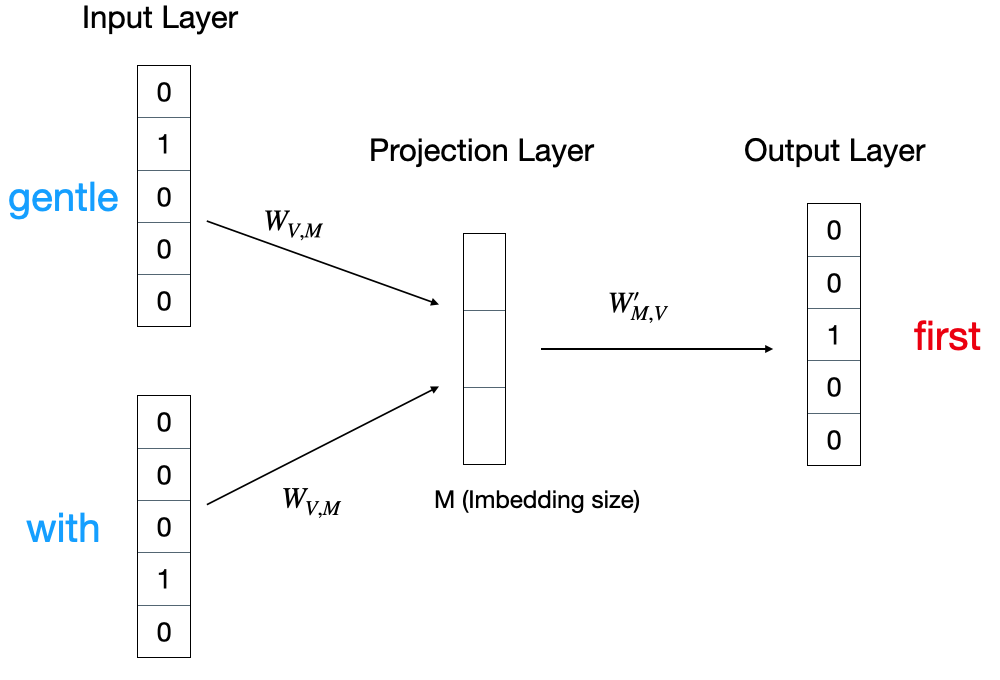

In [12]:
Image('v1.png',width=800)

[CBOW의 과정]  

- (1) 입력값인 주변 단어들이 원핫 인코딩 된다.  
    
- (2) 입력층 -> 투사층  
  
윈도우가 n인 경우에 입력층으로부터 가중치 행렬 W와 곱해져서 투사층에 입력되는 값들의 개수는 2n 이다. 위 그림을 참고할 때, 투사층의 한 Unit의 값은 $v=\frac{{vW_{gentle}}+{vW_{with}}}{2}$와 같이 입력된 각 원핫 인코딩 벡터 간의 평균이다.  
[* 발제자주: 그런데 우리가 pytorch에서 nn.Embedding을 사용하면, 이 평균화를 사용하지 않는 것 같다. 이 nn.Embedding을 사용하면 raw_text의 단어들의 실수로 된  word feature Matrix가 출력되는데, 그 뒤부터는 아래 코드 같이 단지 Forward 연산만 하기 때문이다.] 
  
- (3) 투사층 -> 출력층  
  
투사층 벡터는 $W'$와 곱해짐으로써 다시 입력값의 크기와 동일한 벡터가 된다. 우리는 이 산출된 벡터를 다시 원핫 벡터로 만들기 위해 **softmax**를 사용한다.  
  
- (4) 역전파를 수행하여 $W$,$W'$를 학습시킨다. 여기서 주의할 점은 이들은 전치 transpose 관계가 아닌 서로 다른 가중치일 뿐이다.  
  
- (5) CBOW의 트레이닝 복잡도: Q = ND + DV

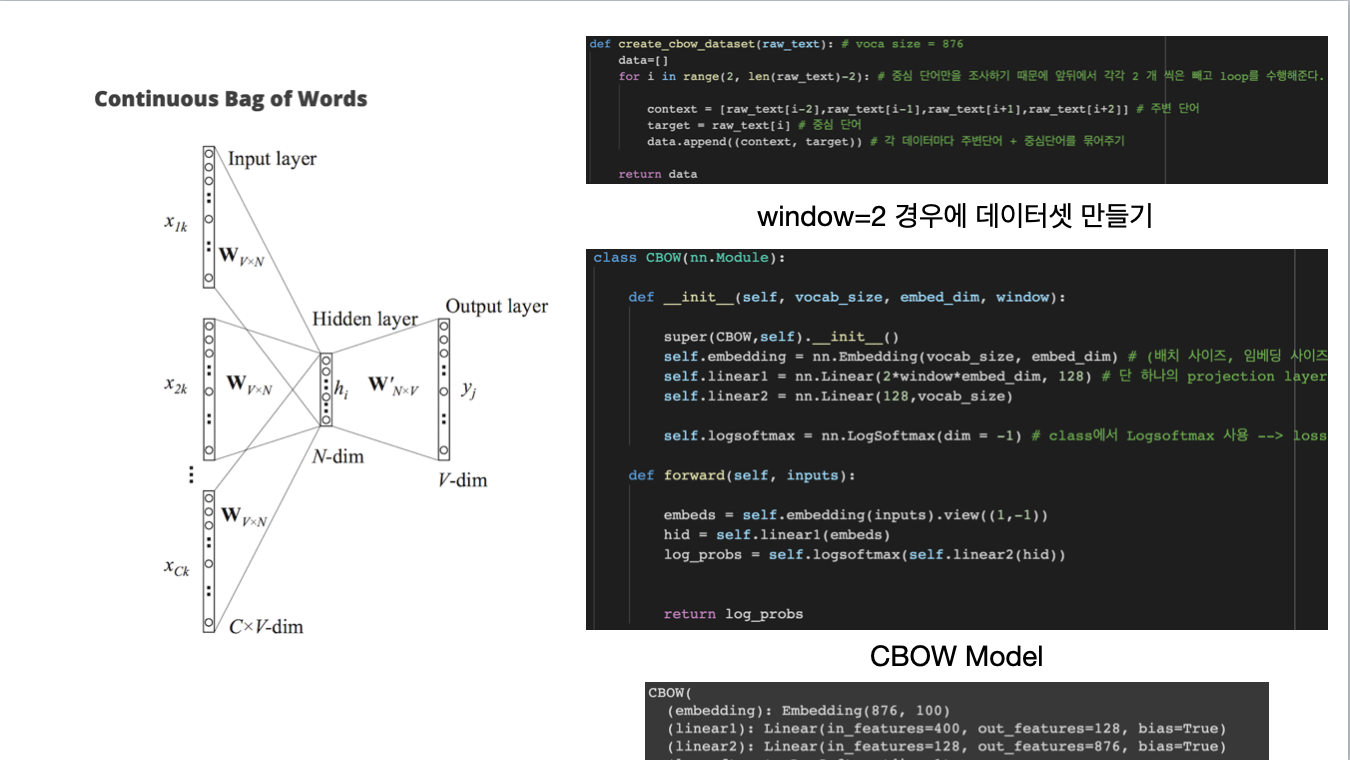

In [26]:
Image('wv5.png')

### 2.2.1 V를 $log_2(V)$로 만들면서 Word2Vec 복잡도를 감소를 시키는 전략  
  
위에서 말했듯이, Word2Vec은 NNLM 보다 더 효율적이다. 우리는 이미 기존의 NNLM의 복잡도 NP + NPH + HV에서 CBOW의 복잡도 ND+DV로 만들었으니 더 효율적인 모델을 알게 된 것이다. 하지만 몇 가지 방법을 통해 V를 $log_2(V)$로 만들 수도 있고, 이것은 더 효율적인 복잡도를 제공해준다.  

(1) Hierarchical Softmax  
  
- 허프만 트리를 이용한 소프트맥스 방법. 이것을 이용하면 연산 복잡도를 $V$에서 $log_2(V)$로 낮출 수 있다고 한다.
  
(2) Negative Sampling  
  
- 

[[[다음 발표 때 이것에 대해 설명]]]

## 2.2 CBOW

In [5]:
# see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

CBOW를 이용하여 Plato의 "향연Symposium"의 앞 부분을 학습시켜보자. 그 뒤에, 이 책의 한 문장 내의 context words를 Test set에 넣은 뒤, 적절한 center word를 찾아내는지 보자. 테스트를 위해 아래의 간략한 실험에서는 "Symposium"의 본문의 한 부분인 "caught a sight of me"를 사용할 것이다. 여기서 context words는 {"caught", "a", "of", "me"}이고, 타겟인 center word는 {"sight"} 이다.

###2.2.1 Plato의 "Symposium" 학습시키기

In [1]:
raw_text = """Concerning the things about which you ask to be informed I believe that I am not ill-prepared with an answer. For the day before yesterday I was coming from my own home at Phalerum to the city, and one of my acquaintance, who had caught a sight of me from behind, hind, out playfully in the distance, said: Apollodorus, O thou Phalerian man, halt! So I did as I was bid; and then he said, I was looking for you, Apollodorus, only just now, that I might ask you about the speeches in praise of love, which were delivered by Socrates, Alcibiades, and others, at Agathon's supper. Phoenix, the son of Philip, told another person who told me of them; his narrative was very indistinct, but he said that you knew, and I wish that you would give me an account of them. Who, if not you, should be the reporter of the words of your friend? And first tell me, he said, were you present at this meeting?

Your informant, Glaucon, I said, must have been very indistinct indeed, if you imagine that the occasion was recent; or that I could have been of the party.

Why, yes, he replied, I thought so.

Impossible: I said. Are you ignorant that for many years Agathon has not resided at Athens; and not three have elapsed since I became acquainted with Socrates, and have made it my daily business to know all that he says and does. There was a time when I was running about the world, fancying myself to be well employed, but I was really a most wretched thing, no better than you are now. I thought that I ought to do anything rather than be a philosopher.

Well, he said, jesting apart, tell me when the meeting occurred.
In our boyhood, I replied, when Agathon won the prize with his first tragedy, on the day after that on which he and his chorus offered the sacrifice of victory.

Then it must have been a long while ago, he said; and who told you-did Socrates?

No indeed, I replied, but the same person who told Phoenix;-he was a little fellow, who never wore any shoes Aristodemus, of the deme of Cydathenaeum. He had been at Agathon's feast; and I think that in those days there was no one who was a more devoted admirer of Socrates. Moreover, I have asked Socrates about the truth of some parts of his narrative, and he confirmed them. Then, said Glaucon, let us have the tale over again; is not the road to Athens just made for conversation? And so we walked, and talked of the discourses on love; and therefore, as I said at first, I am not ill-prepared to comply with your request, and will have another rehearsal of them if you like. For to speak or to hear others speak of philosophy always gives me the greatest pleasure, to say nothing of the profit. But when I hear another strain, especially that of you rich men and traders, such conversation displeases me; and I pity you who are my companions, because you think that you are doing something when in reality you are doing nothing. And I dare say that you pity me in return, whom you regard as an unhappy creature, and very probably you are right. But I certainly know of you what you only think of me-there is the difference.

Companion. I see, Apollodorus, that you are just the same-always speaking evil of yourself, and of others; and I do believe that you pity all mankind, with the exception of Socrates, yourself first of all, true in this to your old name, which, however deserved I know how you acquired, of Apollodorus the madman; for you are always raging against yourself and everybody but Socrates.

Apollodorus. Yes, friend, and the reason why I am said to be mad, and out of my wits, is just because I have these notions of myself and you; no other evidence is required.

Com. No more of that, Apollodorus; but let me renew my request that you would repeat the conversation.

Apoll. Well, the tale of love was on this wise:-But perhaps I had better begin at the beginning, and endeavour to give you the exact words of Aristodemus:

He said that he met Socrates fresh from the bath and sandalled; and as the sight of the sandals was unusual, he asked him whither he was going that he had been converted into such a beau:-

To a banquet at Agathon's, he replied, whose invitation to his sacrifice of victory I refused yesterday, fearing a crowd, but promising that I would come to-day instead; and so I have put on my finery, because he is such a fine man. What say you to going with me unasked?

I will do as you bid me, I replied.
Follow then, he said, and let us demolish the proverb:

To the feasts of inferior men the good unbidden go; instead of which our proverb will run:-

To the feasts of the good the good unbidden go; and this alteration may be supported by the authority of Homer himself, who not only demolishes but literally outrages the proverb. For, after picturing Agamemnon as the most valiant of men, he makes Menelaus, who is but a fainthearted warrior, come unbidden to the banquet of Agamemnon, who is feasting and offering sacrifices, not the better to the worse, but the worse to the better.

I rather fear, Socrates, said Aristodemus, lest this may still be my case; and that, like Menelaus in Homer, I shall be the inferior person, who

To the leasts of the wise unbidden goes. But I shall say that I was bidden of you, and then you will have to make an excuse.

Two going together, he replied, in Homeric fashion, one or other of them may invent an excuse by the way.

This was the style of their conversation as they went along. Socrates dropped behind in a fit of abstraction, and desired Aristodemus, who was waiting, to go on before him. When he reached the house of Agathon he found the doors wide open, and a comical thing happened. A servant coming out met him, and led him at once into the banqueting-hall in which the guests were reclining, for the banquet was about to begin. Welcome, Aristodemus, said Agathon, as soon as he appeared-you are just in time to sup with us; if you come on any other matter put it off, and make one of us, as I was looking for you yesterday and meant to have asked you, if I could have found you. But what have you done with Socrates?

I turned round, but Socrates was nowhere to be seen; and I had to explain that he had been with me a moment before, and that I came by his invitation to the supper.

You were quite right in coming, said Agathon; but where is he himself?

He was behind me just now, as I entered, he said, and I cannot think what has become of him.

Go and look for him, boy, said Agathon, and bring him in; and do you, Aristodemus, meanwhile take the place by Eryximachus.

The servant then assisted him to wash, and he lay down, and presently another servant came in and reported that our friend Socrates had retired into the portico of the neighbouring house. "There he is fixed," said he, "and when I call to him he will not stir."

How strange, said Agathon; then you must call him again, and keep calling him.

Let him alone, said my informant; he has a way of stopping anywhere and losing himself without any reason. I believe that he will soon appear; do not therefore disturb him.

Well, if you think so, I will leave him, said Agathon. And then, turning to the servants, he added, "Let us have supper without waiting for him. Serve up whatever you please, for there; is no one to give you orders; hitherto I have never left you to yourselves. But on this occasion imagine that you art our hosts, and that I and the company are your guests; treat us well, and then we shall commend you." After this, supper was served, but still no-Socrates; and during the meal Agathon several times expressed a wish to send for him, but Aristodemus objected; and at last when the feast was about half over-for the fit, as usual, was not of long duration-Socrates entered; Agathon, who was reclining alone at the end of the table, begged that he would take the place next to him; that "I may touch you," he said, "and have the benefit of that wise thought which came into your mind in the portico, and is now in your possession; for I am certain that you would not have come away until you had found what you sought."

How I wish, said Socrates, taking his place as he was desired, that wisdom could be infused by touch, out of the fuller the emptier man, as water runs through wool out of a fuller cup into an emptier one; if that were so, how greatly should I value the privilege of reclining at your side! For you would have filled me full with a stream of wisdom plenteous and fair; whereas my own is of a very mean and questionable sort, no better than a dream. But yours is bright and full of promise, and was manifested forth in all the splendour of youth the day before yesterday, in the presence of more than thirty thousand Hellenes.

You are mocking, Socrates, said Agathon, and ere long you and I will have to determine who bears off the palm of wisdom-of this Dionysus shall be the judge; but at present you are better occupied with supper.

Socrates took his place on the couch, and supped with the rest; and then libations were offered, and after a hymn had been sung to the god, and there had been the usual ceremonies, they were about to commence drinking, when Pausanias said, And now, my friends, how can we drink with least injury to ourselves? I can assure you that I feel severely the effect of yesterday's potations, and must have time to recover; and I suspect that most of you are in the same predicament, for you were of the party yesterday. Consider then: How can the drinking be made easiest?

I entirely agree, said Aristophanes, that we should, by all means, avoid hard drinking, for I was myself one of those who were yesterday drowned in drink.

I think that you are right, said Eryximachus, the son of Acumenus; but I should still like to hear one other person speak: Is Agathon able to drink hard?

I am not equal to it, said Agathon.
Then, the Eryximachus, the weak heads like myself, Aristodemus, Phaedrus, and others who never can drink, are fortunate in finding that the stronger ones are not in a drinking mood. (I do not include Socrates, who is able either to drink or to abstain, and will not mind, whichever we do.) Well, as of none of the company seem disposed to drink much, I may be forgiven for saying, as a physician, that drinking deep is a bad practice, which I never follow, if I can help, and certainly do not recommend to another, least of all to any one who still feels the effects of yesterday's carouse.

I always do what you advise, and especially what you prescribe as a physician, rejoined Phaedrus the Myrrhinusian, and the rest of the company, if they are wise, will do the same.

It was agreed that drinking was not to be the order of the day, but that they were all to drink only so much as they pleased.

Then, said Eryximachus, as you are all agreed that drinking is to be voluntary, and that there is to be no compulsion, I move, in the next place, that the flute-girl, who has just made her appearance, be told to go away and play to herself, or, if she likes, to the women who are within. To-day let us have conversation instead; and, if you will allow me, I will tell you what sort of conversation. This proposal having been accepted, Eryximachus proceeded as follows:-

I will begin, he said, after the manner of Melanippe in Euripides,

Not mine the word which I am about to speak, but that of Phaedrus. For often he says to me in an indignant tone: "What a strange thing it is, Eryximachus, that, whereas other gods have poems and hymns made in their honour, the great and glorious god, Love, has no encomiast among all the poets who are so many. There are the worthy sophists too-the excellent Prodicus for example, who have descanted in prose on the virtues of Heracles and other heroes; and, what is still more extraordinary, I have met with a philosophical work in which the utility of salt has been made the theme of an eloquent discourse; and many other like things have had a like honour bestowed upon them. And only to think that there should have been an eager interest created about them, and yet that to this day no one has ever dared worthily to hymn Love's praises! So entirely has this great deity been neglected." Now in this Phaedrus seems to me to be quite right, and therefore I want to offer him a contribution; also I think that at the present moment we who are here assembled cannot do better than honour the. god Love. If you agree with me, there will be no lack of conversation; for I mean to propose that each of us in turn, going from left to right, shall make a speech in honour of Love. Let him give us the best which he can; and Phaedrus, because he is sitting first on the left hand, and because he is the father of the thought, shall begin. 
""".split()
# http://classics.mit.edu/Plato/symposium.html

vocab = set(raw_text)
vocab_size = len(vocab)

#w2i, i2W

w2i = {word:i for i, word in enumerate(vocab)}
i2w = {i:word for i,word in enumerate(vocab)}

print("vocab_size:  ",vocab_size)

vocab_size:   876


### context words, target words 분류하기  
  
(1) 두 단어 모음을 분류  
(2) data에 두 모음을 저장

In [6]:
def create_cbow_dataset(raw_text): # voca size = 876
    data=[]
    for i in range(2, len(raw_text)-2): # 중심 단어만을 조사하기 때문에 앞뒤에서 각각 2 개 씩은 빼고 loop를 수행해준다.
    
        context = [raw_text[i-2],raw_text[i-1],raw_text[i+1],raw_text[i+2]] # 주변 단어
        target = raw_text[i] # 중심 단어
        data.append((context, target)) # 각 데이터마다 주변단어 + 중심단어를 묶어주기
        
    return data

In [7]:
cbow_train = create_cbow_dataset(raw_text)
print('cbow_sample: ',cbow_train[:3])

cbow_sample:  [(['Concerning', 'the', 'about', 'which'], 'things'), (['the', 'things', 'which', 'you'], 'about'), (['things', 'about', 'you', 'ask'], 'which')]


### CBOW 모델 만들기

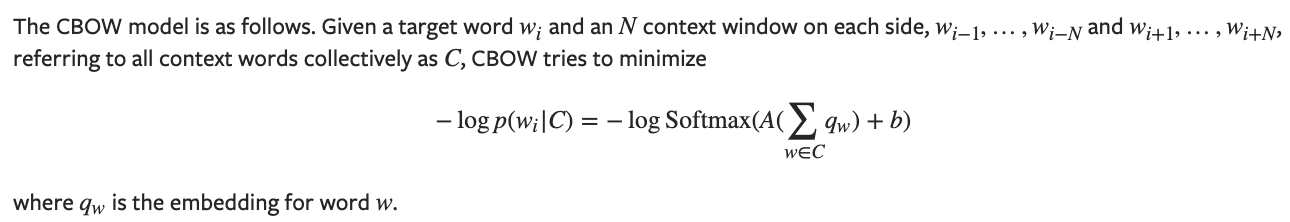

In [26]:
Image('w5.png',width=600)

CBOW(
  (embedding): Embedding(876, 100)
  (linear1): Linear(in_features=400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=876, bias=True)
  (logsoftmax): LogSoftmax(dim=-1)
) 


epoch:  0 cost:  6.689480781555176
epoch:  10 cost:  4.896003723144531
epoch:  20 cost:  2.947740316390991
epoch:  30 cost:  1.1381195783615112
epoch:  40 cost:  0.3836491107940674
epoch:  50 cost:  0.18755091726779938
epoch:  60 cost:  0.11708639562129974
epoch:  70 cost:  0.08320982754230499
epoch:  80 cost:  0.06381534785032272
epoch:  90 cost:  0.05141438543796539
epoch:  100 cost:  0.04286663979291916
epoch:  110 cost:  0.036648642271757126
epoch:  120 cost:  0.0319371223449707
epoch:  130 cost:  0.028252985328435898
epoch:  140 cost:  0.02529880218207836
epoch:  150 cost:  0.022880246862769127
epoch:  160 cost:  0.02086651138961315
epoch:  170 cost:  0.01916498690843582
epoch:  180 cost:  0.017709698528051376
epoch:  190 cost:  0.016451308503746986
context:  ['caught', '

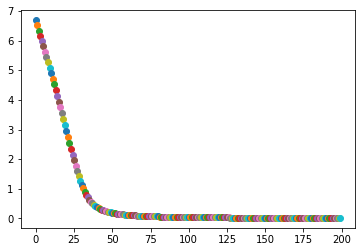

In [24]:
import matplotlib.pylab as plt
%matplotlib inline

def make_context_vector(context, w2i):
    idxs =[w2i[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_dim, window):

        super(CBOW,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) # (배치 사이즈, 임베딩 사이즈)
        self.linear1 = nn.Linear(2*window*embed_dim, 128) # 단 하나의 projection layer 보다 128 개의 projection layers가 있는 것이 더 학습이 잘 돼
        self.linear2 = nn.Linear(128,vocab_size)

        self.logsoftmax = nn.LogSoftmax(dim = -1) # class에서 Logsoftmax 사용 --> loss함수로 NLLLoss 사용

    def forward(self, inputs):

        embeds = self.embedding(inputs).view((1,-1))
        hid = self.linear1(embeds)
        log_probs = self.logsoftmax(self.linear2(hid))
       

        return log_probs

    def get_word_embedding(self, word):

        word = torch.tensor([w2i[word]])
        return self.embedding(word).view(1,-1)


if __name__ == "__main__":

    window = 2 # 왼쪽 오른쪽으로 2 개씩 context words를 조사  
    EMBEDDING_DIM = 100

    data = create_cbow_dataset(raw_text)
    model = CBOW(vocab_size, EMBEDDING_DIM, window)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    print(model,'\n\n')
    # 트레이닝

    for epoch in range(200):

        total_loss = 0

        for context, target in data: # ([contexts, target])의 집합이 있는 data
            context_vector = make_context_vector(context, w2i)
            
            log_probs = model(context_vector)

            total_loss = loss_fn(log_probs, torch.tensor([w2i[target]]))
        
        if (epoch)%10 ==0:
                print('epoch: ', epoch, 'cost: ', total_loss.item()) 
                
        # matplotlib

        plt.plot(epoch,total_loss.item(),marker='o')

        
        # 매 epoch 마다 최적화

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # 테스트
    
    context = ['caught','a','of', 'me'] # caught a sight of me
    context_vector = make_context_vector(context,w2i)
    testing_model = model(context_vector)

    # 결과 출력

    #Print result

    print('context: ',context,'\n')
    print('Predicted center word: ', i2w[torch.argmax(testing_model).item()])
   

# 3. Skip - Gram

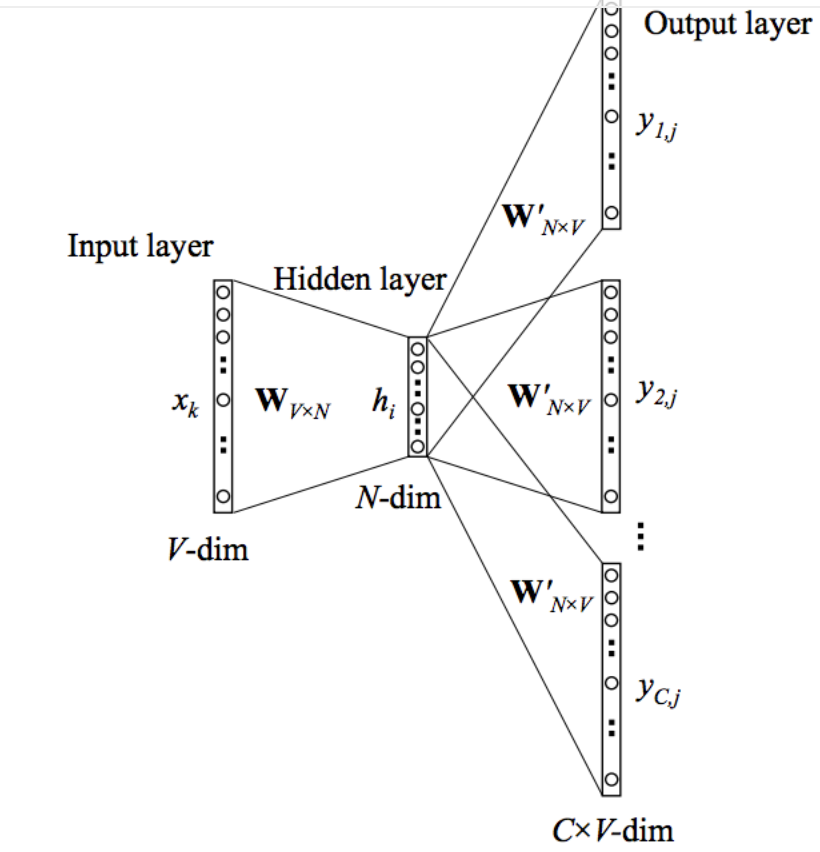

In [28]:
Image('t1.png',width=600)

스킵 그램은 CBOW와 반대의 형태를 갖는 방법이다. 이것은 중심 단어로부터 주변 단어를 예측한다.

## References  
[1] Mikolov, Tomas, et al. "Distributed representations of words and phrases and their compositionality." Advances in neural information processing systems. 2013.  

[2] Mikolov, Tomas, et al. "Efficient estimation of word representations in vector space." arXiv preprint arXiv:1301.3781 (2013)  
[3]https://github.com/musicjae/NLP/blob/master/Word2Vec/Word2Vec(2)%20Mikolov.%20et%20al%2C%20%E2%80%98Efficient%20Estimation%20of%20Word%20Representations%20in%20Vector%20Space%E2%80%99%20(2013)%20%20.pdf 위 [2] 논문에 대한 국역 요약글을 이곳에 정리해두었다.  

[4] https://wikidocs.net/22660  
[5] https://github.com/FraLotito/pytorch-continuous-bag-of-words/blob/master/cbow.py  
[6] https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/  
[7]https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#word-embeddings-in-pytorch  
[8] https://github.com/jojonki/word2vec-pytorch/blob/master/word2vec.ipynb